In [7]:
#%load_ext snakeviz
%matplotlib inline

In [8]:
#librerias utilitarias
from random import randint
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt

In [9]:
#librerias Keras
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adadelta, Adagrad

Dado que Tensorflow esta optimizado para funcionar sobre GPU la creación de los modelos se realizo sobre una maquina virtual EC2 de AWS (Amazon Web Service) del tipo p2.xlarge, cuando se ejecuta Keras en jupyter nos entrega la siguiente información :

~~~python
I tensorflow/core/common_runtime/gpu/gpu_device.cc:887] Found device 0 with properties:
name: Tesla K80
major: 3 minor: 7 memoryClockRate (GHz) 0.8235
pciBusID 0000:00:1e.0
Total memory: 11.17GiB
Free memory: 11.11GiB
~~~


**Nota:**Como es conocido las redes convolucionales contienen dentro de arquitectura procesos computing intensive, principalmente por la cantidad de operaciones matriciales que se realizan por ejemplo en la misma operación de convolución que les da el nombre. Es por esto que para dar soporte al crecimiento de DeepLearning han aparecido librerías como TensorFlow sobre ella Keras para dar soporte a esta capacidad de computo, principalmente sobre GPU.Como aprendizaje extra, motivado por mis propios intereses, se apunto a buscar soluciones que permitieran la paralelización de estas operaciones. Asociado a lo anterior y motivado por la posibilidad de usar, por periodos de tiempos, una maquina del tipo p2.8xlarge AWS(Amazon Web Service) que tiene 8 tarjetas GPU NVidia K80. 

Podemos ver todas las GPU’s disponibles con el comando de Nvidia:

In [4]:
!nvidia-smi

Fri Jun 16 01:15:29 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.39                 Driver Version: 375.39                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 0000:00:17.0     Off |                    0 |
| N/A   63C    P0    60W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 0000:00:18.0     Off |                    0 |
| N/A   51C    P0    71W / 149W |      0MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

## 2.- CNNs en Google Street View
---

En esta seccion, trabajaremos con el dataset SVHN (Street View House Numbers), correspondiente a imagenes naturales de dıgitos de direcciones obtenidos desde Google Street View. El dataset contiene mas de 600.000 imagenes de entrenamiento y 26.032 imagenes de test. Para facilitar la realizacion de experimentos, el dataset de entrenamiento se divide usualmente en un conjunto pequeno de 73.257 imagenes y un conjunto “extra” de 531.131 imagenes. **En esta tarea trabajaremos solo con la version pequena**. Los valientes pueden verificar que entrenando sobre el conjunto grande los resultados mejoran significativamente.

### Archivos

![title](google1.png)

Los datos pueden ser obtenidos (en formato Matlab) ejecutando los siguientes comandos
~~~python
wget http://ufldl.stanford.edu/housenumbers/train_32x32.mat
wget http://ufldl.stanford.edu/housenumbers/extra_32x32.mat
wget http://ufldl.stanford.edu/housenumbers/test_32x32.mat
~~~

**(a)** Cargue los datos de entrenamiento y pruebas (“train 32x32.mat” y “test 32x32.mat”). Determine el tamaño de las imagenes, el numero de clases diferentes y de ejemplos en cada categoría. Finalmente, visualice 5 imágenes de entrenamiento y 5 de test (elegidas aleatoriamente). Comente.

El dataset esta en formato Matlab para leer se usa la función sio de scipy, a partir de train_32x32.mat se construye el dataset de entrenamiento y a su vez de test_32x32.mat el dataset de testing. 

In [10]:
#%%snakeviz
train_data = sio.loadmat('data/train_32x32.mat')
test_data = sio.loadmat('data/test_32x32.mat')
X_train = train_data['X'].T
y_train = train_data['y'] - 1
X_test = test_data['X'].T
y_test = test_data['y'] - 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
n_classes = len(np.unique(y_train))
print (np.unique(y_train))

[0 1 2 3 4 5 6 7 8 9]


In [14]:
print (X_train.shape)
print (X_test.shape)
print (y_train.shape)
print (y_test.shape)

(73257, 3, 32, 32)
(26032, 3, 32, 32)
(73257, 1)
(26032, 1)


Se usará un dataset de **entrenamiento de tamaño 73257** y un dataset de **test de tamaño 26032**. Ademas podemos constatar que estamos trabajando con **imágenes de 3 canales, 32 filas y 32 columnas.**

Ahora veremos el tamaño de cada categoría:

In [16]:
print ("\nDataset de entrenamiento por categoria:")
for i in np.unique(y_train):
    print ("Categoria",str(i), ":", str(np.where(y_train==i)[0].shape[0]))

print ("\nDataset de prueba por categoria:")
for i in np.unique(y_test):
    print ("Categoria",str(i), ":", str(np.where(y_test==i)[0].shape[0]))



Dataset de entrenamiento por categoria:
('Categoria', '0', ':', '13861')
('Categoria', '1', ':', '10585')
('Categoria', '2', ':', '8497')
('Categoria', '3', ':', '7458')
('Categoria', '4', ':', '6882')
('Categoria', '5', ':', '5727')
('Categoria', '6', ':', '5595')
('Categoria', '7', ':', '5045')
('Categoria', '8', ':', '4659')
('Categoria', '9', ':', '4948')

Dataset de prueba por categoria:
('Categoria', '0', ':', '5099')
('Categoria', '1', ':', '4149')
('Categoria', '2', ':', '2882')
('Categoria', '3', ':', '2523')
('Categoria', '4', ':', '2384')
('Categoria', '5', ':', '1977')
('Categoria', '6', ':', '2019')
('Categoria', '7', ':', '1660')
('Categoria', '8', ':', '1595')
('Categoria', '9', ':', '1744')


**Nota:** Un detalle importante, que debe ser considerado al momento de entrenar la red, es el hecho que hay un desbalance notorio en las categorías en el dataset de entrenamiento. Como vemos las categorias 1 y 0 tienen un numero mayor a las demás categorías, existen técnicas como aumentar el dataset en las otras clases que podría servir en este caso.


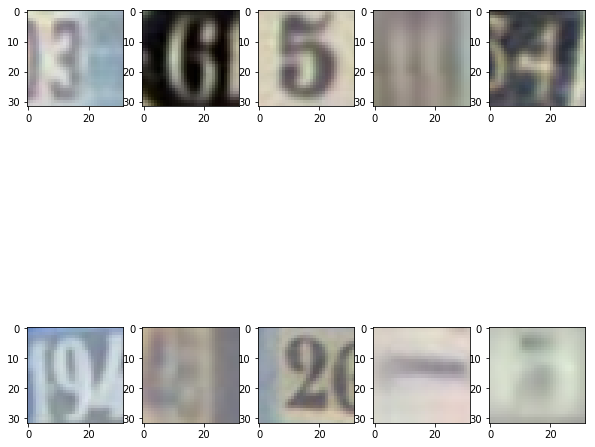

In [17]:
fig, ax = plt.subplots(nrows=2,ncols=5,figsize=(10,10))
fig.subplots_adjust(hspace = 0.0001,wspace = 0.2,left  = 0.125,bottom = 0.001 )
aux = 'entrenamiento'
for row in ax:
    for col in row:
        if(aux == 'entrenamiento'):
            col.imshow(X_train[randint(0,len(X_train))].T)
        else:
            col.imshow(X_test[randint(0,len(X_test))].T)
    aux == 'test'
plt.show()

**(b)** Normalice las imagenes, dividiendo las intensidades originales de pixel por 255. Represente adecuadamente la salida deseada de la red de modo de tener un vector de tamano igual al numero de clases.

Antes seguir avanzo hay que verificar que el que el  índice correspondiente a los canales de una imagen de entrada sea consistente con las operaciones aquí realizadas. Al verificar el archivo keras.json, tenemos la siguiente configuración:

~~~python
{
    "epsilon": 1e-07,
    "floatx": "float32",
    "image_data_format": "channels_last",
    "backend": "tensorflow"
}
~~~

Donde cada la variable `"image_data_format": "channels_last" `siginfica que para imagenes en 2D data  tenemos el siguiente formato:
- **`"channels_last"`** implica -> (samples, height, width, **channels**)
- **`"channels_first"`** implica -> (samples, **channels**, height, width)




**Normalización:** Como es conocido la no-linealidad de las funciones que se usan en las redes convolucionales, como ReLU, trabajan en intervalos muy acotados por lo cual debe normalizarse el dataset para evitar la saturación de estas funciones.


In [18]:
from keras.utils import np_utils
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

(73257, 3, 32, 32)
(26032, 3, 32, 32)
(73257, 10)
(26032, 10)


Como podemos ver la variable `"image_data_format": "channels_last" ` **no** esta correctamente seteada pues los datos se encuentran en el formato(samples, **channels**, height, width). Por lo cual se debe cambiar la configuración de keras.json


In [8]:
cat $HOME/.keras/keras.json

{
    "floatx": "float32",
    "epsilon": 1e-07,
    "backend": "tensorflow",
    "image_data_format": "channels_first"
}


In [9]:
from keras import backend as K
K.image_data_format()

'channels_first'